In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', None)       # Показывать все строки
pd.set_option('display.max_columns', None)    # Показывать все столбцы
pd.set_option('display.width', None)          # Не ограничивать ширину вывода
pd.set_option('display.max_colwidth', None)

In [ ]:
df=pd.read_csv('dataset_for_sirius.csv', sep=";")
print("размер датафрейма", len(df))
num_columns = df.shape[1]
print(f"Количество столбцов: {num_columns}")

размер датафрейма 593433
Количество столбцов: 246


In [ ]:
# df.head()

,expiration_minus_1d_dt,id,target,renewal_amt,one_prc_loyalty_accrual_rub_amt,sovokupnyj_balans,sovokupnye_traty,median_monthly_income_amt,monthly_income_amt,avg_integral_cur_rur_balance,avg_out_puc,credit_amt_norm_cls_max,tarif_id,months_cnt,renewal_cnt,target_cashback_amt,target_lifestyle_cashback_amt,target_merch_cashback_amt,target_bnk_cashback_amt,high_category_loyalty_accrual_rub_amt,high_category_loyalty_accrual_bns_amt,first_category,second_category,third_category,sum_second_category,sum_third_category,3+_aktivnyh_produkta,Deneg_bolee_100tys,Deneg_bolee_10tys,Traty_bolee_10tys,Private,IFL,Strahovanie_ipoteki,Oteli,Kasko,Karshering,VZR,Sovmestnyj_schet,Vklad,IIS,Premium,Travel,Oplatil_toplivo_v_Tinkoff_Gorod,Sharing_scheta,Oplatil_shtraf,Avtoplatezh,LifeStyle,Kubyshka,Popolnjal_brokerskij,Dopka_na_3_litso,Biznes_schet,Osago,Poluchaet_ZP,Privel_druga,used_special_offer,ZhKH,Poluchil_mezhbankovskij_perevod,Podpiski_na_servisy,Junior,Est'_mobajl,Investkopilka,Pro,Nakopitel'nyj_schet,Taksi,NS_keptivnaja_strahovka,Popolnil_v_bankomate,Zapravki,Podpiska_na_shtrafy,Brokerskij_schet,Perevod_po_telefonu_karte_so_sbera,Dostavka_edy,Odezhda_elektronika,Oplata_SBP_po_QR,Ecom,Obschestvennyj_transport,Internet,Mobil'naja_svjaz',Kafe_restorany_fastfud,Onlajn_tranzaktsija,Kreditnyj_produkt,Ishodjaschij_SBP_perevod,Supermarket,Poluchil_vhodjaschij_SBP,Est'_DK,party_rk_count,Mobajl_kontaktnyj_nomer,count_top_friends,max_count_of_close_mob,time_since_utilization_brk,time_since_opened_mob,full_time_mob,count_of_utils_mob,count_of_open_brk,count_of_ever_opened_tcn,count_of_ever_opened_ccr,count_of_all_open,age,min_age,use_sum_month_12_cnt,use_union_month_cnt,delay_m4_cnt,accnt_auto_cnt,zkr_open_accnt_cnt,days_cred_use_sum,accnt_rev_cnt,accnt_cnt,max_out_tel_mbk_cnt,max_out_puc_cnt,max_days_from_open_dt_min,out_request_cnt_sum,out_request_cnt_3,out_request_cnt_3_sum,out_request_cnt,median_friend_lifetime,median_count_of_ever_opened_cor,median_turnover,mpl_std_time,education_level_cd,marital_status_cd,risk_level_cd,authorization_type_cd,time_zone_delta_tm,gender_cd,days_from_bki_request_dt_max,days_from_open_dt_max,days_from_open_dt_min,avg_friend_lifetime,avg_count_of_utils_lon,stddev_total_curr_balance,avg_in_c2c_int_amt,avg_in_sbp_cnt,avg_purchase_interchange_fee_amt,avg_total_cur_balance,avg_turnover,avg_out_request_cnt_3,avg_credit_amt_opn_rev_sum,avg_out_request_cnt,avg_delay_m4_cnt,avg_credit_amt_norm_cls_max,avg_hl_delay_log,longitude,avg_education_level,gender_rate,ipl_perc,ratio_outstnd_credit_rev,cur_delqbalance_max,log_p_q_av,zkr_debt_sum,cred_av_log,hl_delay_log,credit_amt_opn_rev_sum,outstnd_amt_opn_nrev_sum,outst_rate,wrst_delqbalance_max,diff_sovkombank_24_max,diff_sovkombank_12_max,diff_sovkombank_6_max,diff_sovkombank_3_max,diff_sber_24_max,diff_sber_12_max,diff_sber_6_max,diff_sber_3_max,diff_sber_2_max,diff_russkiy_standart_24_max,diff_russkiy_standart_12_max,diff_russkiy_standart_6_max,diff_russkiy_standart_3_max,diff_rosselkhoz_24_max,diff_rosselkhoz_12_max,diff_rosselkhoz_6_max,diff_rosselkhoz_3_max,diff_rayffayzen_24_max,diff_rayffayzen_12_max,diff_rayffayzen_6_max,diff_rayffayzen_3_max,diff_promsvyazbank_24_max,diff_promsvyazbank_12_max,diff_promsvyazbank_6_max,diff_promsvyazbank_3_max,diff_psb_24_max,diff_psb_12_max,diff_psb_6_max,diff_psb_3_max,diff_mkb_24_max,diff_mkb_12_max,diff_mkb_6_max,diff_mkb_3_max,diff_mkb_2_max,diff_gazprombank_24_max,diff_gazprombank_12_max,diff_gazprombank_6_max,diff_gazprombank_3_max,diff_vtb_24_max,diff_vtb_12_max,diff_vtb_6_max,diff_vtb_3_max,diff_alfa_bank_24_max,diff_alfa_bank_12_max,diff_alfa_bank_6_max,diff_alfa_bank_3_max,diff_sovkombank_24_mean,diff_sovkombank_12_mean,diff_sovkombank_6_mean,diff_sovkombank_3_mean,diff_sber_24_mean,diff_sber_12_mean,diff_sber_6_mean,diff_sber_3_mean,diff_sber_2_mean,diff_russkiy_standart_24_mean,diff_russkiy_standart_12_mean,diff_russkiy_standart_6_mean,diff_russkiy_standart_3_mean,diff_rosselkhoz_24_mean,diff_rosselkhoz_12_mean,diff_rosselkhoz_6_

### Замена t f на 1 0 соответственно

In [ ]:
# Проходим по всем столбцам датафрейма
for column in df.columns:
    # Получаем уникальные значения в столбце
    unique_values = df[column].unique()
    # Проверяем, совпадают ли уникальные значения с ['t', 'f'] (без учета порядка)
    if set(unique_values) == {'t', 'f'}:
        # Заменяем 't' на 1 и 'f' на 0
        df[column] = df[column].map({'t': 1, 'f': 0})

# Теперь df содержит замененные значения в соответствующих столбцах

### Обработка кешбека

In [ ]:
# cashback_category_flg - столбец с флагом (0/1), что хотя бы одна категория кешбека выбрана

df['cashback_category_flg'] = (
    df[['first_category', 'second_category', 'third_category']]
    .notna()
    .any(axis=1)
    .astype(int)
)

## Очистка данных

### Удаление избыточных столбцов

In [ ]:
# unique_values = df['tarif_id'].unique()  # массив NumPy
# print(unique_values)
# df = df.drop('tarif_id', axis=1)
# df = df.drop(columns = ['Oplatil_toplivo_v_Tinkoff_Gorod', 'Mobajl_kontaktnyj_nomer', 'gender_rate', 'Vklad','avg_purchase_interchange_fee_amt'])
# df=df.drop(columns=['count_top_friends', 'count_of_open_brk', 'time_since_opened_mob', 'time_since_utilization_brk', 'max_count_of_close_mob', 'min_age', 'delay_m4_cnt', 'accnt_auto_cnt','zkr_open_accnt_cnt','days_cred_use_sum','accnt_rev_cnt'])


#  'max_count_of_close_mob',

In [ ]:
df=df.drop(columns=[ 'tarif_id', 'Oplatil_toplivo_v_Tinkoff_Gorod', 'Mobajl_kontaktnyj_nomer', 'gender_rate', 'Vklad','avg_purchase_interchange_fee_amt', 'count_top_friends', 'count_of_open_brk', 'time_since_opened_mob', 'time_since_utilization_brk', 'min_age',  'accnt_auto_cnt', 'days_cred_use_sum','accnt_rev_cnt',
                    "max_days_from_open_dt_min", "out_request_cnt_sum", "out_request_cnt_3", "out_request_cnt_3_sum", "out_request_cnt", "median_friend_lifetime", "mpl_std_time", "authorization_type_cd", "time_zone_delta_tm", "days_from_bki_request_dt_max", "days_from_open_dt_max",  "days_from_open_dt_min", "avg_friend_lifetime", "avg_in_c2c_int_amt", "avg_in_sbp_cnt", "avg_out_request_cnt_3", "avg_purchase_interchange_fee_amt",
                    "avg_out_request_cnt_3", "avg_purchase_interchange_fee_amt", "avg_out_request_cnt", "longitude", "avg_education_level"])

In [ ]:
num_columns = df.shape[1]
print(f"Количество столбцов: {num_columns}")

Количество столбцов: 247


### Замена выбросов

In [ ]:
df.age = df.age.fillna(df.age.median())
df = df[df.age >=14]



df.use_union_month_cnt = df.use_union_month_cnt.fillna(df.use_union_month_cnt.median())
df.use_union_month_cnt = np.where(
    df.use_union_month_cnt > 228,
    df.use_union_month_cnt.median(),
    df.use_union_month_cnt)

df.use_sum_month_12_cnt = df.use_sum_month_12_cnt.fillna(df.use_sum_month_12_cnt.median())
df.use_sum_month_12_cnt = np.where(
    df.use_sum_month_12_cnt > 12,
    df.use_sum_month_12_cnt.median(),
    df.use_sum_month_12_cnt)

df.max_count_of_close_mob = df.max_count_of_close_mob.fillna(df.use_sum_month_12_cnt.median())
df.max_count_of_close_mob = np.where(
    df.max_count_of_close_mob > df.max_count_of_close_mob.quantile(0.99),
    df.use_sum_month_12_cnt.median(),
    df.use_sum_month_12_cnt)

df.count_of_utils_mob = df.count_of_utils_mob.fillna(df.count_of_utils_mob.median())
df = df[~(df.count_of_utils_mob == 55.0)]

df.count_of_ever_opened_ccr = df.count_of_ever_opened_ccr.fillna(df.count_of_ever_opened_ccr.median())
df.count_of_ever_opened_ccr = df.count_of_ever_opened_ccr.replace({43.0: df.count_of_ever_opened_ccr.median()})

df.count_of_ever_opened_ccr = df.count_of_ever_opened_ccr.fillna(df.count_of_ever_opened_ccr.median())
df.count_of_ever_opened_ccr = df.count_of_ever_opened_ccr.replace({43.0: df.count_of_ever_opened_ccr.median()})


df.full_time_mob = df.full_time_mob.fillna(df.full_time_mob.median())

df.count_of_ever_opened_tcn = df.count_of_ever_opened_tcn.fillna(df.count_of_ever_opened_tcn.median())

df.count_of_all_open = df.count_of_all_open.fillna(df.count_of_all_open.median())

df.delay_m4_cnt = df.delay_m4_cnt.fillna(df.delay_m4_cnt.median())

df.zkr_open_accnt_cnt = df.zkr_open_accnt_cnt.fillna(df.zkr_open_accnt_cnt.median())




<ipython-input-63-a4753c0b723a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.use_union_month_cnt = df.use_union_month_cnt.fillna(df.use_union_month_cnt.median())
<ipython-input-63-a4753c0b723a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.count_of_ever_opened_ccr = df.count_of_ever_opened_ccr.fillna(df.count_of_ever_opened_ccr.median())
<ipython-input-63-a4753c0b723a>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [ ]:

# Sasha

df.iloc[:, 132] = df.iloc[:, 132].abs()
df.iloc[:, 132] = df.iloc[:, 132].fillna(df.iloc[:, 132].median())
df.iloc[:, 133] = df.iloc[:, 133].abs()
df.iloc[:, 133] = df.iloc[:, 133].fillna(df.iloc[:, 133].median())
df.iloc[:, 135] = df.iloc[:, 135].fillna(df.iloc[:, 135].median())
df.iloc[:, 137] = df.iloc[:, 137].fillna(df.iloc[:, 137].median())
df.iloc[:, 138] = df.iloc[:, 138].fillna(df.iloc[:, 138].median())
df.iloc[:, 141] = df.iloc[:, 141].fillna(df.iloc[:, 141].median())

### Объединение столбцов с подписками (Pro, Premium, Private)

In [ ]:
df['Account_Type'] = np.select(
    condlist=[
        df['Pro'] == 1,
        df['Premium'] == 1,
        df['Private'] == 1
    ],
    choicelist=[1, 2, 3],
    default=0  # если ни одно условие не выполнилось
)

# Удаляем старые столбцы
df = df.drop(['Private', 'Premium', 'Pro'], axis=1)

### Замена категориальных значений сумм

In [ ]:
for col in ['renewal_amt', 'one_prc_loyalty_accrual_rub_amt', 'sovokupnyj_balans', 'sovokupnye_traty'
    , 'median_monthly_income_amt', 'monthly_income_amt', 'avg_integral_cur_rur_balance', 'avg_out_puc'
    , 'credit_amt_norm_cls_max']:
    unique_values = df[col].unique()  # массив NumPy

    # print()
    # print(col)
    # print(list(unique_values))
    # print(df[col].isna().sum())

    df[col] = df[col].map(
        {'<500': 0, '<1000': 1, '<10000': 2, '<50000': 20, '<100000': 100, '<500000': 200, '<1400000': 1000,
         '>=1400000': 2800})

    median_value = df[col].dropna().median()
    # print(f"Медиана (NaN удалены вручную): {median_value}")
    # print()
    df[col] = df[col].fillna(median_value)

# print(df.head())

### Агрегация полей с суммой кешбека по категория

In [ ]:
cashback_sum = ['sum_second_category', 'sum_third_category']
df['sum_cashback_categ'] = df[['sum_second_category', 'sum_third_category']].sum(axis = 1)
df = df.drop(columns = cashback_sum)
df.loc[df['sum_cashback_categ'] < 0, 'sum_cashback_categ'] = 0

In [ ]:
pos_val = df['target_cashback_amt'][df['target_cashback_amt'] >= 0]
median = pos_val.median()
df['target_cashback_amt'] = df['target_cashback_amt'].where(df['target_cashback_amt'] >= 0, median)
df['target_cashback_amt'] = df['target_cashback_amt'].where(df['target_cashback_amt'] <= 3960, median)

In [ ]:
pos_val = df['target_lifestyle_cashback_amt'][df['target_lifestyle_cashback_amt'] >= 0]
median = pos_val.median()
df['target_lifestyle_cashback_amt'] = df['target_lifestyle_cashback_amt'].where(df['target_lifestyle_cashback_amt'] >= 0, median)
df['target_lifestyle_cashback_amt'] = df['target_lifestyle_cashback_amt'].where(df['target_lifestyle_cashback_amt'] <= 454, median)

In [ ]:
pos_val = df['target_merch_cashback_amt'][df['target_merch_cashback_amt'] >= 0]
median = pos_val.median()
df['target_merch_cashback_amt'] = df['target_merch_cashback_amt'].where(df['target_merch_cashback_amt'] >= 0, median)
df['target_merch_cashback_amt'] = df['target_merch_cashback_amt'].where(df['target_merch_cashback_amt'] <= 2796, median)

In [ ]:
pos_val = df['target_bnk_cashback_amt'][df['target_bnk_cashback_amt'] >= 0]
median = pos_val.median()
df['target_bnk_cashback_amt'] = df['target_bnk_cashback_amt'].where(df['target_bnk_cashback_amt'] >= 0, median)
df['target_bnk_cashback_amt'] = df['target_bnk_cashback_amt'].where(df['target_bnk_cashback_amt'] <= 1652, median)

In [ ]:
target_cashback_sum = ['target_cashback_amt', 'target_lifestyle_cashback_amt', 'target_merch_cashback_amt', 'target_bnk_cashback_amt']
df['sum_cashback_target'] = df[target_cashback_sum].sum(axis = 1)
df = df.drop(columns = target_cashback_sum)

In [ ]:
pos_val = df['high_category_loyalty_accrual_rub_amt'][df['high_category_loyalty_accrual_rub_amt'] >= 0]
median = pos_val.median()
df['high_category_loyalty_accrual_rub_amt'] = df['high_category_loyalty_accrual_rub_amt'].where(df['high_category_loyalty_accrual_rub_amt'] >= 0, median)
df['high_category_loyalty_accrual_rub_amt'] = df['high_category_loyalty_accrual_rub_amt'].where(df['high_category_loyalty_accrual_rub_amt'] <= 5213, median)

In [ ]:
pos_val = df['high_category_loyalty_accrual_bns_amt'][df['high_category_loyalty_accrual_bns_amt'] >= 0]
median = pos_val.median()
df['high_category_loyalty_accrual_bns_amt'] = df['high_category_loyalty_accrual_bns_amt'].where(df['high_category_loyalty_accrual_bns_amt'] >= 0, median)
df['high_category_loyalty_accrual_bns_amt'] = df['high_category_loyalty_accrual_bns_amt'].where(df['high_category_loyalty_accrual_bns_amt'] <= 795, median)

### Группируем флаги страховок в один столбец, дропаем

In [ ]:
insurance_columns = ['IFL', 'Strahovanie_ipoteki', 'Kasko', 'VZR', 'Osago', 'NS_keptivnaja_strahovka']
for column in insurance_columns:
    counts = df[column].value_counts(dropna = False)
    # print(counts)
    nan_count = df[column].isna().sum()
    # print(nan_count)
df['insurance'] = df[insurance_columns].sum(axis = 1)

# df = df.drop(columns = insurance_columns)


### Группируем флаги транзакций в один столбец, дропаем

In [ ]:
transactions_columns = ['Oteli', 'Karshering', 'Travel', 'Oplatil_shtraf', 'LifeStyle', 'ZhKH', 'Taksi'
                , 'Zapravki', 'Dostavka_edy', 'Odezhda_elektronika', 'Ecom', 'Obschestvennyj_transport'
                , 'Internet', "Mobil'naja_svjaz'", 'Kafe_restorany_fastfud', 'Onlajn_tranzaktsija'
                , 'Supermarket']

for column in transactions_columns:
    counts = df[column].value_counts(dropna = False)
    # print(counts)
    nan_count = df[column].isna().sum()
    # print(nan_count)
df['transactions'] = df[transactions_columns].sum(axis = 1)

# df = df.drop(columns = transactions_columns)


In [ ]:
df.head()

,expiration_minus_1d_dt,id,target,renewal_amt,one_prc_loyalty_accrual_rub_amt,sovokupnyj_balans,sovokupnye_traty,median_monthly_income_amt,monthly_income_amt,avg_integral_cur_rur_balance,avg_out_puc,credit_amt_norm_cls_max,tarif_id,months_cnt,renewal_cnt,high_category_loyalty_accrual_rub_amt,high_category_loyalty_accrual_bns_amt,first_category,second_category,third_category,3+_aktivnyh_produkta,Deneg_bolee_100tys,Deneg_bolee_10tys,Traty_bolee_10tys,IFL,Strahovanie_ipoteki,Oteli,Kasko,Karshering,VZR,Sovmestnyj_schet,Vklad,IIS,Travel,Oplatil_toplivo_v_Tinkoff_Gorod,Sharing_scheta,Oplatil_shtraf,Avtoplatezh,LifeStyle,Kubyshka,Popolnjal_brokerskij,Dopka_na_3_litso,Biznes_schet,Osago,Poluchaet_ZP,Privel_druga,used_special_offer,ZhKH,Poluchil_mezhbankovskij_perevod,Podpiski_na_servisy,Junior,Est'_mobajl,Investkopilka,Nakopitel'nyj_schet,Taksi,NS_keptivnaja_strahovka,Popolnil_v_bankomate,Zapravki,Podpiska_na_shtrafy,Brokerskij_schet,Perevod_po_telefonu_karte_so_sbera,Dostavka_edy,Odezhda_elektronika,Oplata_SBP_po_QR,Ecom,Obschestvennyj_transport,Internet,Mobil'naja_svjaz',Kafe_restorany_fastfud,Onlajn_tranzaktsija,Kreditnyj_produkt,Ishodjaschij_SBP_perevod,Supermarket,Poluchil_vhodjaschij_SBP,Est'_DK,party_rk_count,Mobajl_kontaktnyj_nomer,count_top_friends,max_count_of_close_mob,time_since_utilization_brk,time_since_opened_mob,full_time_mob,count_of_utils_mob,count_of_open_brk,count_of_ever_opened_tcn,count_of_ever_opened_ccr,count_of_all_open,age,min_age,use_sum_month_12_cnt,use_union_month_cnt,delay_m4_cnt,accnt_auto_cnt,zkr_open_accnt_cnt,days_cred_use_sum,accnt_rev_cnt,accnt_cnt,max_out_tel_mbk_cnt,max_out_puc_cnt,max_days_from_open_dt_min,out_request_cnt_sum,out_request_cnt_3,out_request_cnt_3_sum,out_request_cnt,median_friend_lifetime,median_count_of_ever_opened_cor,median_turnover,mpl_std_time,education_level_cd,marital_status_cd,risk_level_cd,authorization_type_cd,time_zone_delta_tm,gender_cd,days_from_bki_request_dt_max,days_from_open_dt_max,days_from_open_dt_min,avg_friend_lifetime,avg_count_of_utils_lon,stddev_total_curr_balance,avg_in_c2c_int_amt,avg_in_sbp_cnt,avg_purchase_interchange_fee_amt,avg_total_cur_balance,avg_turnover,avg_out_request_cnt_3,avg_credit_amt_opn_rev_sum,avg_out_request_cnt,avg_delay_m4_cnt,avg_credit_amt_norm_cls_max,avg_hl_delay_log,longitude,avg_education_level,gender_rate,ipl_perc,ratio_outstnd_credit_rev,cur_delqbalance_max,log_p_q_av,zkr_debt_sum,cred_av_log,hl_delay_log,credit_amt_opn_rev_sum,outstnd_amt_opn_nrev_sum,outst_rate,wrst_delqbalance_max,diff_sovkombank_24_max,diff_sovkombank_12_max,diff_sovkombank_6_max,diff_sovkombank_3_max,diff_sber_24_max,diff_sber_12_max,diff_sber_6_max,diff_sber_3_max,diff_sber_2_max,diff_russkiy_standart_24_max,diff_russkiy_standart_12_max,diff_russkiy_standart_6_max,diff_russkiy_standart_3_max,diff_rosselkhoz_24_max,diff_rosselkhoz_12_max,diff_rosselkhoz_6_max,diff_rosselkhoz_3_max,diff_rayffayzen_24_max,diff_rayffayzen_12_max,diff_rayffayzen_6_max,diff_rayffayzen_3_max,diff_promsvyazbank_24_max,diff_promsvyazbank_12_max,diff_promsvyazbank_6_max,diff_promsvyazbank_3_max,diff_psb_24_max,diff_psb_12_max,diff_psb_6_max,diff_psb_3_max,diff_mkb_24_max,diff_mkb_12_max,diff_mkb_6_max,diff_mkb_3_max,diff_mkb_2_max,diff_gazprombank_24_max,diff_gazprombank_12_max,diff_gazprombank_6_max,diff_gazprombank_3_max,diff_vtb_24_max,diff_vtb_12_max,diff_vtb_6_max,diff_vtb_3_max,diff_alfa_bank_24_max,diff_alfa_bank_12_max,diff_alfa_bank_6_max,diff_alfa_bank_3_max,diff_sovkombank_24_mean,diff_sovkombank_12_mean,diff_sovkombank_6_mean,diff_sovkombank_3_mean,diff_sber_24_mean,diff_sber_12_mean,diff_sber_6_mean,diff_sber_3_mean,diff_sber_2_mean,diff_russkiy_standart_24_mean,diff_russkiy_standart_12_mean,diff_russkiy_standart_6_mean,diff_russkiy_standart_3_mean,diff_rosselkhoz_24_mean,diff_rosselkhoz_12_mean,diff_rosselkhoz_6_mean,diff_rosselkhoz_3_mean,diff_rayffayzen_24_mean,diff_rayffayzen_12_mean,diff_rayffayzen_6_mean,diff_rayffayzen_3_mean,diff_promsvyazbank_24_mean,diff_proms

In [ ]:
percentiles = df['renewal_cnt'].quantile([0.5, 0.9, 0.95, 0.99])
print("Процентили renewal_cnt:")
print(percentiles)

median_value = df['renewal_cnt'].dropna().median()
# Заменяем значения > 6 на медиану
df['renewal_cnt'] = df['renewal_cnt'].apply(lambda x: median_value if x > 6 else x)

Процентили renewal_cnt:
0.50    1.0
0.90    2.0
0.95    3.0
0.99    6.0
Name: renewal_cnt, dtype: float64


In [ ]:
num_columns = df.shape[1]
print(f"Количество столбцов: {num_columns}")

Количество столбцов: 243


## Модель по выявлению фичей, оказывающих  наибольшее влияние

### LGBMClassifier (улучшенная версия)

[LightGBM] [Info] Number of positive: 96187, number of negative: 378557
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.244772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 101
[LightGBM] [Info] Number of data points in the train set: 474744, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Accuracy: 0.61
Precision: 0.28
Recall: 0.59
F1 Score: 0.38
ROC AUC: 0.65


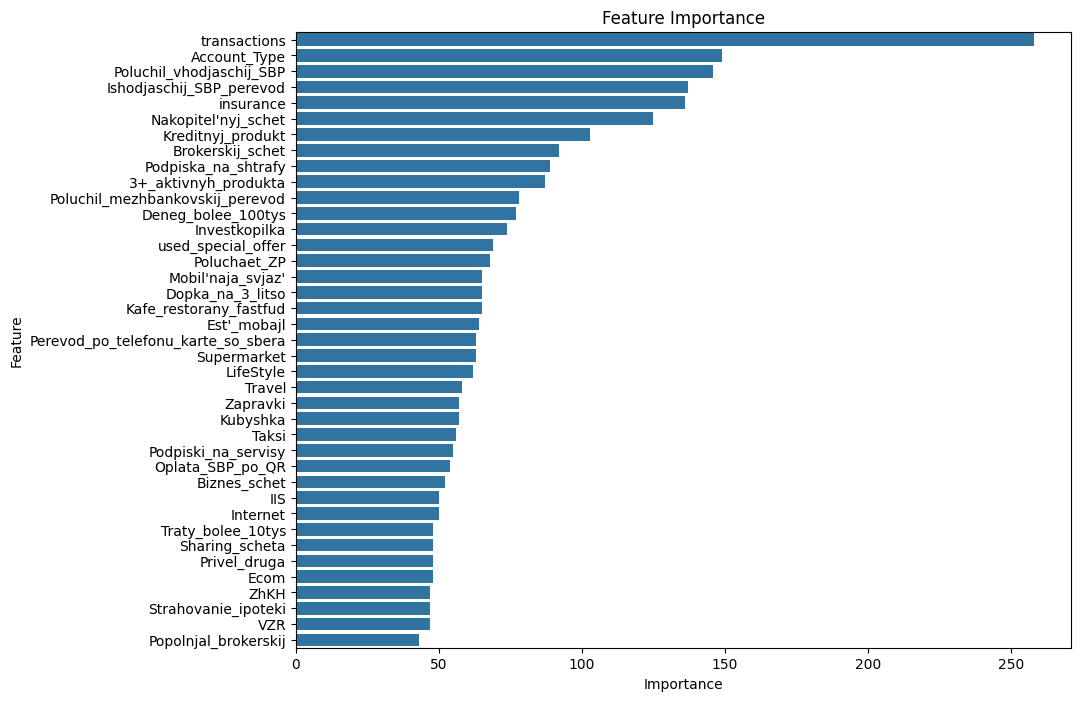

Top features influencing user retention (target=0):
                     Feature  Importance
0               transactions         258
2               Account_Type         149
1   Poluchil_vhodjaschij_SBP         146
3   Ishodjaschij_SBP_perevod         137
7                  insurance         136
5        Nakopitel'nyj_schet         125
4          Kreditnyj_produkt         103
13          Brokerskij_schet          92
6        Podpiska_na_shtrafy          89
10      3+_aktivnyh_produkta          87


In [ ]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
# Предположим, что у вас есть DataFrame df с признаками и целевой переменной 'target'
# df = pd.read_csv('your_data.csv')
fields = [
    "transactions",
    "Poluchil_vhodjaschij_SBP",
    "Account_Type",
    "Ishodjaschij_SBP_perevod",
    "Kreditnyj_produkt",
    "Nakopitel'nyj_schet",
    "Podpiska_na_shtrafy",
    "insurance",
    "Poluchil_mezhbankovskij_perevod",
    "Deneg_bolee_100tys",
    "3+_aktivnyh_produkta",
    "Kubyshka",
    "Podpiski_na_servisy",
    "Brokerskij_schet",
    "Perevod_po_telefonu_karte_so_sbera",
    "used_special_offer",
    "Poluchaet_ZP",
    "Mobil'naja_svjaz'",
    "Traty_bolee_10tys",
    "Investkopilka",
    "Travel",
    "Supermarket",
    "Taksi",
    "Zapravki",
    "Popolnjal_brokerskij",
    "ZhKH",
    "Sharing_scheta",
    "Est'_mobajl",
    "Dopka_na_3_litso",
    "Strahovanie_ipoteki",
    "Ecom",
    "Oplata_SBP_po_QR",
    "Privel_druga",
    "VZR",
    "LifeStyle",
    "Biznes_schet",
    "Kafe_restorany_fastfud",
    "Internet",
    "IIS"
]

X = df[fields]

y = df['target']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Создание и обучение модели LightGBM
model = lgb.LGBMClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Предсказания и оценка модели
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Важность признаков
feature_importances = model.feature_importances_
features = X.columns

# Создание DataFrame с важностью признаков
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Визуализация важности признаков
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

# Вывод наиболее значимых признаков
print("Top features influencing user retention (target=0):")
print(importance_df.head(10))


### LGBMClassifier (первая версия)

In [ ]:

columns_to_keep = [
    'IFL', 'Strahovanie_ipoteki', 'Kasko', 'VZR', 'Osago', 'NS_keptivnaja_strahovka',
    'Oteli', 'Karshering', 'Travel', 'Oplatil_toplivo_v_Tinkoff_Gorod', 'Oplatil_shtraf',
    'LifeStyle', 'ZhKH', 'Taksi', 'Zapravki', 'Dostavka_edy', 'Odezhda_elektronika',
    'Ecom', 'Obschestvennyj_transport', 'Internet', "Mobil'naja_svjaz'",
    'Kafe_restorany_fastfud', 'Onlajn_tranzaktsija', 'Supermarket',
    '3+_aktivnyh_produkta', 'Deneg_bolee_100tys', 'Deneg_bolee_10tys', 'Traty_bolee_10tys',
    'Poluchaet_ZP', 'Sovmestnyj_schet', 'IIS', 'Sharing_scheta', 'Kubyshka',
    'Popolnjal_brokerskij', 'Dopka_na_3_litso', 'Biznes_schet', 'Privel_druga',
    'Junior', "Est'_mobajl", 'Investkopilka', "Nakopitel'nyj_schet", 'Brokerskij_schet',
    'Kreditnyj_produkt', "Est'_DK", 'used_special_offer', 'Poluchil_mezhbankovskij_perevod',
    'Perevod_po_telefonu_karte_so_sbera', 'Oplata_SBP_po_QR', 'Ishodjaschij_SBP_perevod',
    'Poluchil_vhodjaschij_SBP', "transactions", "insurance", "Account_Type",  "Podpiska_na_shtrafy",
    "Podpiski_na_servisy","Avtoplatezh"]

[LightGBM] [Info] Number of positive: 96081, number of negative: 378663
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.336258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 135
[LightGBM] [Info] Number of data points in the train set: 474744, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202385 -> initscore=-1.371455
[LightGBM] [Info] Start training from score -1.371455
Важность признаков по версии LightGBM:
                               feature  importance
50                        transactions         183
49            Poluchil_vhodjaschij_SBP         133
52                        Account_Type         130
48            Ishodjaschij_SBP_perevod         124
42                   Kreditnyj_produkt         109
40                 Nakopitel'nyj_schet          88
53                 Podpiska_na_shtrafy       

100%|===================| 118591/118687 [09:38<00:00]       

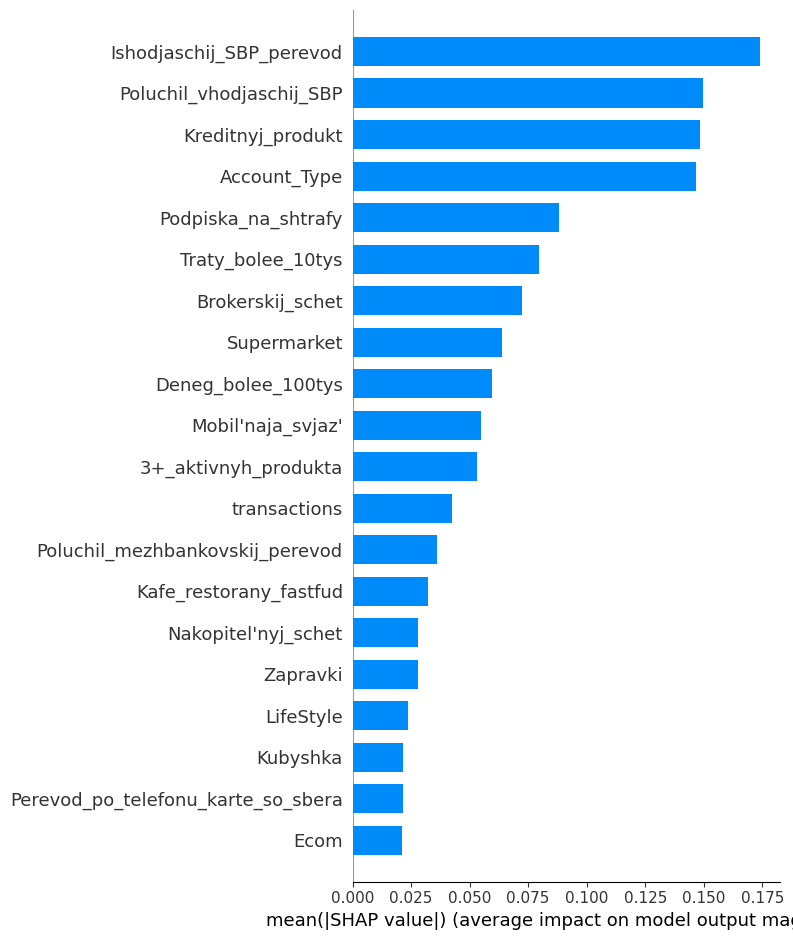

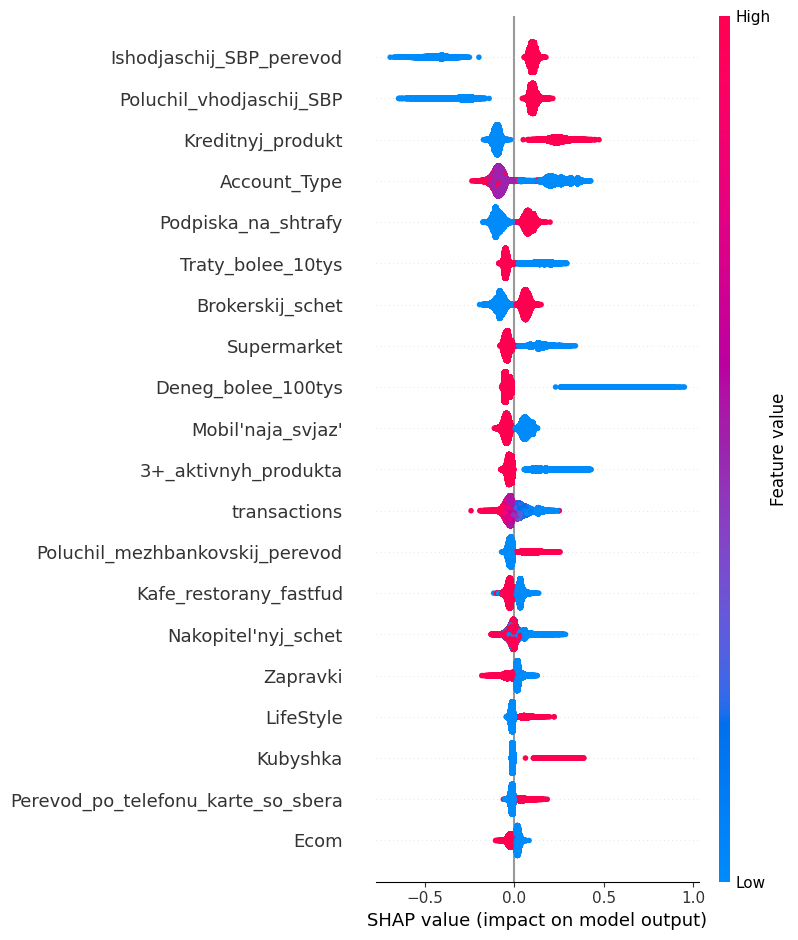

In [ ]:
y = df['target']

# Ваш список колонок для сохранения
columns_to_keep = [
    'IFL', 'Strahovanie_ipoteki', 'Kasko', 'VZR', 'Osago', 'NS_keptivnaja_strahovka',
    'Oteli', 'Karshering', 'Travel', 'Oplatil_toplivo_v_Tinkoff_Gorod', 'Oplatil_shtraf',
    'LifeStyle', 'ZhKH', 'Taksi', 'Zapravki', 'Dostavka_edy', 'Odezhda_elektronika',
    'Ecom', 'Obschestvennyj_transport', 'Internet', "Mobil'naja_svjaz'",
    'Kafe_restorany_fastfud', 'Onlajn_tranzaktsija', 'Supermarket',
    '3+_aktivnyh_produkta', 'Deneg_bolee_100tys', 'Deneg_bolee_10tys', 'Traty_bolee_10tys',
    'Poluchaet_ZP', 'Sovmestnyj_schet', 'IIS', 'Sharing_scheta', 'Kubyshka',
    'Popolnjal_brokerskij', 'Dopka_na_3_litso', 'Biznes_schet', 'Privel_druga',
    'Junior', "Est'_mobajl", 'Investkopilka', "Nakopitel'nyj_schet", 'Brokerskij_schet',
    'Kreditnyj_produkt', "Est'_DK", 'used_special_offer', 'Poluchil_mezhbankovskij_perevod',
    'Perevod_po_telefonu_karte_so_sbera', 'Oplata_SBP_po_QR', 'Ishodjaschij_SBP_perevod',
    'Poluchil_vhodjaschij_SBP', "transactions", "insurance", "Account_Type",  "Podpiska_na_shtrafy",
    "Podpiski_na_servisy","Avtoplatezh"]

X = df[columns_to_keep]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

feature_importances = model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

print("Важность признаков по версии LightGBM:")
print(importance_df)

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

shap.summary_plot(shap_values, X_test)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Предсказания на тестовой выборке
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Вычисление метрик
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Вывод метрик
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

### Важные признаки CatBoost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool




X = df[columns_to_keep]
y = df['target']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)


model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=20
)

model.fit(
    train_pool,
    eval_set=test_pool,
    plot=True  #
)


feature_importances = model.get_feature_importance()
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)


plt.figure(figsize=(14, 10))
plt.barh(
    importance_df['Feature'].head(20)[::-1],
    importance_df['Importance'].head(20)[::-1],
    color='skyblue'
)
plt.xlabel('Важность признака')
plt.title('Топ-20 важных признаков по CatBoost')
plt.tight_layout()
plt.show()


print("Важность признаков:")
print(importance_df)

In [ ]:
bamk_produ = ['3+_aktivnyh_produkta', 'Deneg_bolee_100tys', 'Deneg_bolee_10tys', 'Traty_bolee_10tys', 'Poluchaet_ZP', 'Sovmestnyj_schet', 'IIS', 'Sharing_scheta', 'Kubyshka', 'Popolnjal_brokerskij', 'Dopka_na_3_litso', 'Biznes_schet', 'Privel_druga', 'Junior', 'Est_mobajl', 'Investkopilka', 'Nakopitelnyj_schet', 'Brokerskij_schet', 'Kreditnyj_produkt', 'Est_DK', 'Used_special_offer']